This tutorial is a follow-along guide for the tutorials found at [TBD].

Data Source:

De Cock, D. (2011). Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project. Journal of Statistics Education, 19(3). https://doi.org/10.1080/10691898.2011.11889627

In [1]:
!pip install xgboost


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from pyreal.sample_applications import ames_housing

X, y = ames_housing.load_data(include_targets=True)
X.iloc[:,0:12].head()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood
0,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown
1,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide
2,20,RL,70.0,11200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer
3,60,RL,85.0,11924,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt
4,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,Sawyer


In [3]:
y.head()

0    129900
1    118000
2    129500
3    345000
4    144000
Name: SalePrice, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
from pyreal.transformers import OneHotEncoder, StandardScaler, fit_transformers
from pyreal.sample_applications.ames_housing import AmesHousingImputer

transformers = [
    AmesHousingImputer(),
    OneHotEncoder(columns="all_categorical", handle_unknown="ignore"),
    StandardScaler()
]

fit_transformers(transformers, X_train);

In [6]:
from pyreal.transformers import run_transformers
from xgboost import XGBRegressor

X_train_model = run_transformers(transformers, X_train)
X_test_model = run_transformers(transformers, X_test)

model = XGBRegressor(n_estimators=200, learning_rate=.1,
                     max_depth=2, subsample=.8)
model.fit(X_train_model, y_train)

model.score(X_test_model, y_test)

0.9201314946925315

In [7]:
pred = model.predict(X_test_model.iloc[0:3])
for i in range(3):
  print(f"House {i}: Predicted {pred[i]}, Actual {y_test.iloc[i]}")

House 0: Predicted 105914.84375, Actual 102000
House 1: Predicted 196280.15625, Actual 191000
House 2: Predicted 118196.8671875, Actual 89471


In [8]:
houses = ames_housing.load_sample_houses()
houses.head()

,Address,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,312 Oakway Lane,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal
1,3699 Jenna Lane,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,3880 Hazelwood Avenue,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,842 Jenna Lane,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,1580 Cameron Road,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml


In [9]:
from pyreal import RealApp

feature_descriptions = ames_housing.load_feature_descriptions()

realapp = RealApp(model,
                  X_train_orig=X_train,
                  y_train=y_train,
                  transformers=transformers,
                  id_column="Address",
                  feature_descriptions=feature_descriptions,
                  pred_format_func=lambda x: f"${x:,.2f}")

In [10]:
predictions = realapp.predict(houses)

print(f"Predicted price for 3880 Hazelwood Avenue: {predictions['3880 Hazelwood Avenue']}")

Predicted price for 3880 Hazelwood Avenue: $170,706.12


[10:24:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


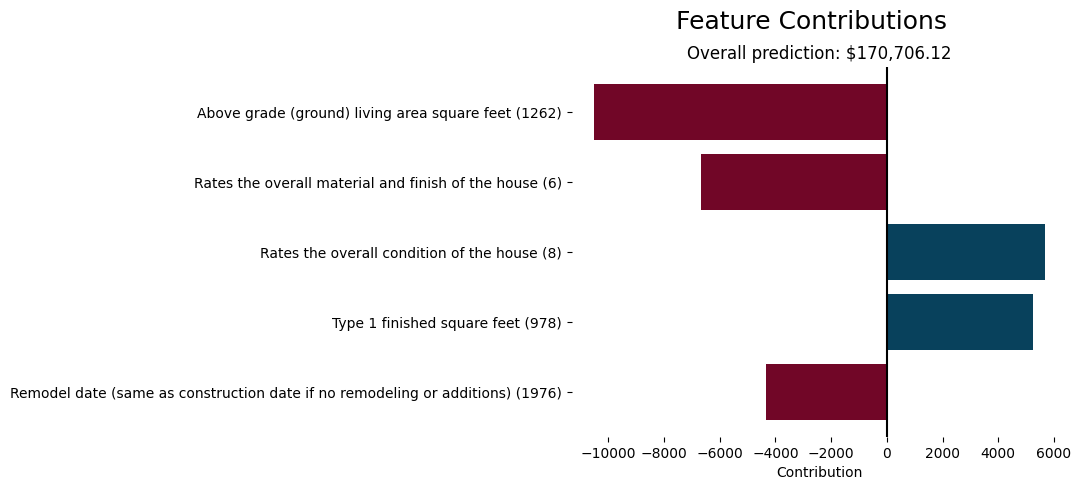

In [11]:
from pyreal.visualize import feature_bar_plot

contribution_scores = realapp.produce_feature_contributions(houses)
feature_bar_plot(contribution_scores["3880 Hazelwood Avenue"],
                 prediction=predictions["3880 Hazelwood Avenue"],
                 num_features=5)

[10:24:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


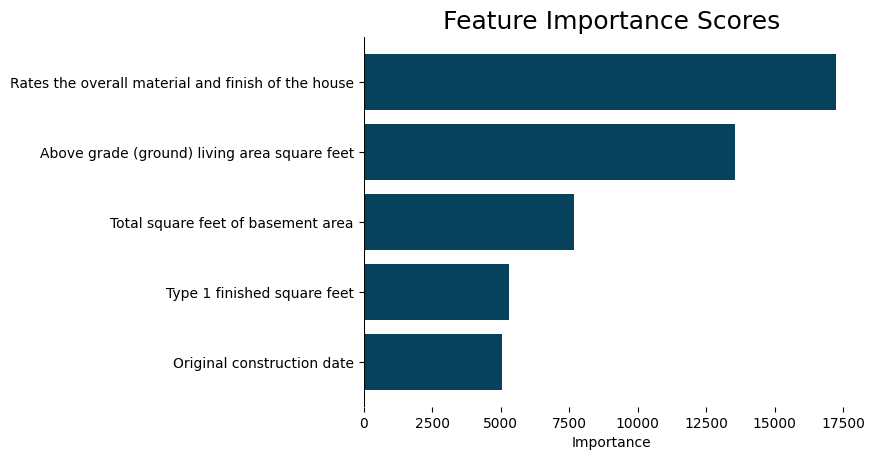

In [12]:
importance_scores = realapp.produce_feature_importance()
feature_bar_plot(importance_scores)

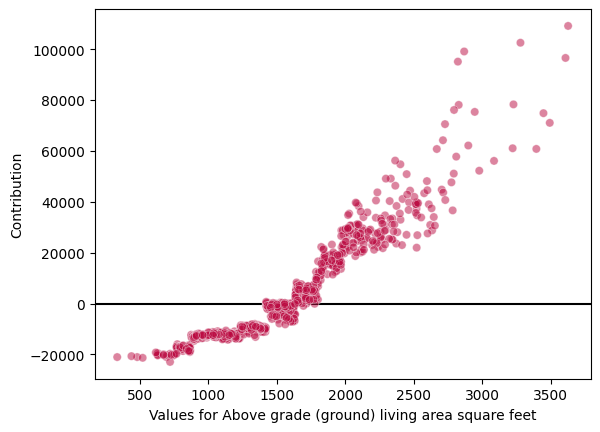

In [13]:
from pyreal.visualize import feature_scatter_plot

all_contributions = realapp.produce_feature_contributions(X_train)

feature_scatter_plot(all_contributions,
                     feature="Above grade (ground) living area square feet")


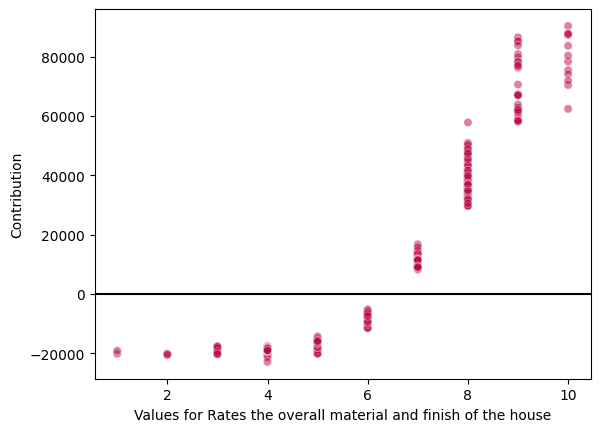

In [14]:
feature_scatter_plot(all_contributions,
                     feature="Rates the overall material and finish of the house")

In [15]:
from pyreal.visualize import example_table

similar_houses = realapp.produce_similar_examples(houses,
                                                  num_examples=2)

example_table(similar_houses["3880 Hazelwood Avenue"], show_only_different=True)

,Ground Truth,Identifies the type of dwelling involved in the sale.,Lot size in square feet,General shape of property,Lot configuration,Proximity to various conditions,Style of dwelling,Rates the overall material and finish of the house,Rates the overall condition of the house,Original construction date,...,Bedrooms above grade (does NOT include basement bedrooms),Kitchen quality,Total rooms above grade (does not include bathrooms),Year garage was built,Interior finish of the garage,Size of garage in square feet,Wood deck area in square feet,Open porch area in square feet,Month Sold (MM),Year Sold (YYYY)
Original Input,N/A,20,9600,Reg,FR2,Feedr,1Story,6,8,1976,...,3,TA,6,1976,RFn,460,298,0,5,2007
664,"$165,000.00",20,11250,IR1,Inside,Norm,1Story,6,6,1977,...,3,TA,6,1977.0,RFn,546,198,42,6,2006
1156,"$194,000.00",80,16157,IR1,FR2,Feedr,SLvl,5,7,1978,...,2,Gd,5,1978.0,Unf,588,168,180,6,2007
